## CV Assignment 3 - Task 1

Name: Muhammad Fahad Waqar<br>
Student No: st125981

In [1]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
import os

In [2]:
def get_person_bbox(model, img, threshold=0.7):
    # Define the image transformations
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    preprocess = weights.transforms()
    
    # Apply transformations
    img_tensor = preprocess(img)
    
    # Add a batch dimension
    img_tensor = img_tensor.unsqueeze(0)
    
    # Perform inference
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensor)
    
    # COCO class ID for 'person' is 1
    person_class_id = 1
    
    boxes = []
    scores = []
    
    for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
        if label == person_class_id and score > threshold:
            boxes.append(box.cpu().numpy().astype(int))
            scores.append(score.cpu().numpy())
    
    if not boxes:
        return None
    
    # Return the box with the highest score
    best_box = boxes[np.argmax(scores)]
    return (best_box[0], best_box[1], best_box[2] - best_box[0], best_box[3] - best_box[1])

def run_grabcut(img_bgr, rect, iterations):
    # Create a mask initialized with background
    mask = np.zeros(img_bgr.shape[:2], np.uint8)
    
    # GrabCut requires temporary arrays
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    
    # Run GrabCut
    # The function modifies the mask in-place
    cv2.grabCut(img_bgr, mask, rect, bgdModel, fgdModel, iterations, cv2.GC_INIT_WITH_RECT)
    
    # Create a final mask where 0 and 2 are background, 1 and 3 are foreground
    final_mask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD), 0, 1).astype('uint8')
    
    # Apply the mask to the original image
    img_fg = img_bgr * final_mask[:, :, np.newaxis]
    
    # Create an overlay (foreground + 0.3 * background)
    img_overlay = img_bgr.copy()
    bg_mask = 1 - final_mask
    img_overlay[bg_mask.astype(bool)] = (img_overlay[bg_mask.astype(bool)] * 0.3).astype(np.uint8)
    img_overlay = cv2.addWeighted(img_fg, 1, img_overlay, 0.0, 0)
    img_overlay[final_mask == 1] = img_fg[final_mask == 1]
    
    return final_mask, img_fg, img_overlay

def plot_results(img_rgb, rect, results_dict):
    num_iterations = len(results_dict.keys())
    
    # We need 2 (original, bbox) + num_iterations * 2 (fg, overlay)
    num_plots = 2 + num_iterations * 2
    
    plt.figure(figsize=(20, 10))
    
    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')
    
    # Bounding Box
    img_with_box = cv2.cvtColor(np.array(img_rgb), cv2.COLOR_RGB2BGR)
    (x, y, w, h) = rect
    cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)
    img_with_box = cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 3, 2)
    plt.imshow(img_with_box)
    plt.title('Detected BBox (User Mask)')
    plt.axis('off')
    
    # Plotting results for each iteration
    plot_index = 3
    for iters, (mask, fg, overlay) in results_dict.items():
        # Plot Foreground Only
        plt.subplot(2, 3, plot_index)
        plt.imshow(cv2.cvtColor(fg, cv2.COLOR_BGR2RGB))
        plt.title(f'Foreground ({iters} iters)')
        plt.axis('off')
        plot_index += 1
        
        # Plot Overlay
        plt.subplot(2, 3, plot_index)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f'Overlay ({iters} iters)')
        plt.axis('off')
        plot_index += 1
        
        if plot_index > 6:
            break # Max 6 plots for this layout

    plt.tight_layout()
    plt.show()

In [9]:
def main():
    # Load the pre-trained Faster R-CNN model
    print("Loading model...")
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)
    model.eval()
    print("Model loaded.")

    image_files = ['../assets/asm-1.jpg', '../assets/asm-2.jpg']
    iteration_counts = [1, 3, 5]

    for img_file in image_files:
        if not os.path.exists(img_file):
            print(f"ERROR: Image file '{img_file}' not found. Please make sure it's in the same directory.")
            continue
            
        print(f"\nProcessing {img_file}")
        try:
            # Load image
            img_pil = Image.open(img_file).convert('RGB')
            img_rgb = np.array(img_pil)
            img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

            # Get Bounding Box
            rect = get_person_bbox(model, img_pil)
            
            if rect is None:
                print(f"No person found in {img_file}. Skipping.")
                continue
            
            print(f"Found person with bounding box: {rect}")
            (x, y, w, h) = rect
            
            # Run GrabCut for 1, 3, and 5 iterations
            results = {}
            pixel_counts = {}
            
            for iters in iteration_counts:
                print(f"Running GrabCut for {iters} iteration(s)...")
                final_mask, img_fg, img_overlay = run_grabcut(img_bgr.copy(), rect, iters)
                results[iters] = (final_mask, img_fg, img_overlay)
                pixel_counts[iters] = np.sum(final_mask)
                
            # Report quantitative and qualitative differences
            print("\nQuantitative Differences:")
            for iters, count in pixel_counts.items():
                print(f"  - {iters} iterations: {count} pixels")
            
            print("\nQualitative Differences:")
            print("1 iteration: It gives a rough outline and may miss complex parts.")
            print("3 iterations: This is generally a good refinement, captures more detail.")
            print("5 iterations: Further refinement, but may start to 'bleed' into the background.")
            
            # 4. Visualize Results
            plot_results(img_rgb, rect, results)

        except FileNotFoundError:
            print(f"ERROR: Image file '{img_file}' not found. Please upload it.")
        except Exception as e:
            print(f"An error occurred processing {img_file}: {e}")

Loading model...
Model loaded.

Processing ../assets/asm-1.jpg
Found person with bounding box: (np.int64(263), np.int64(63), np.int64(89), np.int64(235))
Running GrabCut for 1 iteration(s)...
Running GrabCut for 3 iteration(s)...
Running GrabCut for 5 iteration(s)...

Quantitative Differences:
  - 1 iterations: 13261 pixels
  - 3 iterations: 13158 pixels
  - 5 iterations: 13142 pixels

Qualitative Differences:
1 iteration: It gives a rough outline and may miss complex parts.
3 iterations: This is generally a good refinement, captures more detail.
5 iterations: Further refinement, but may start to 'bleed' into the background.


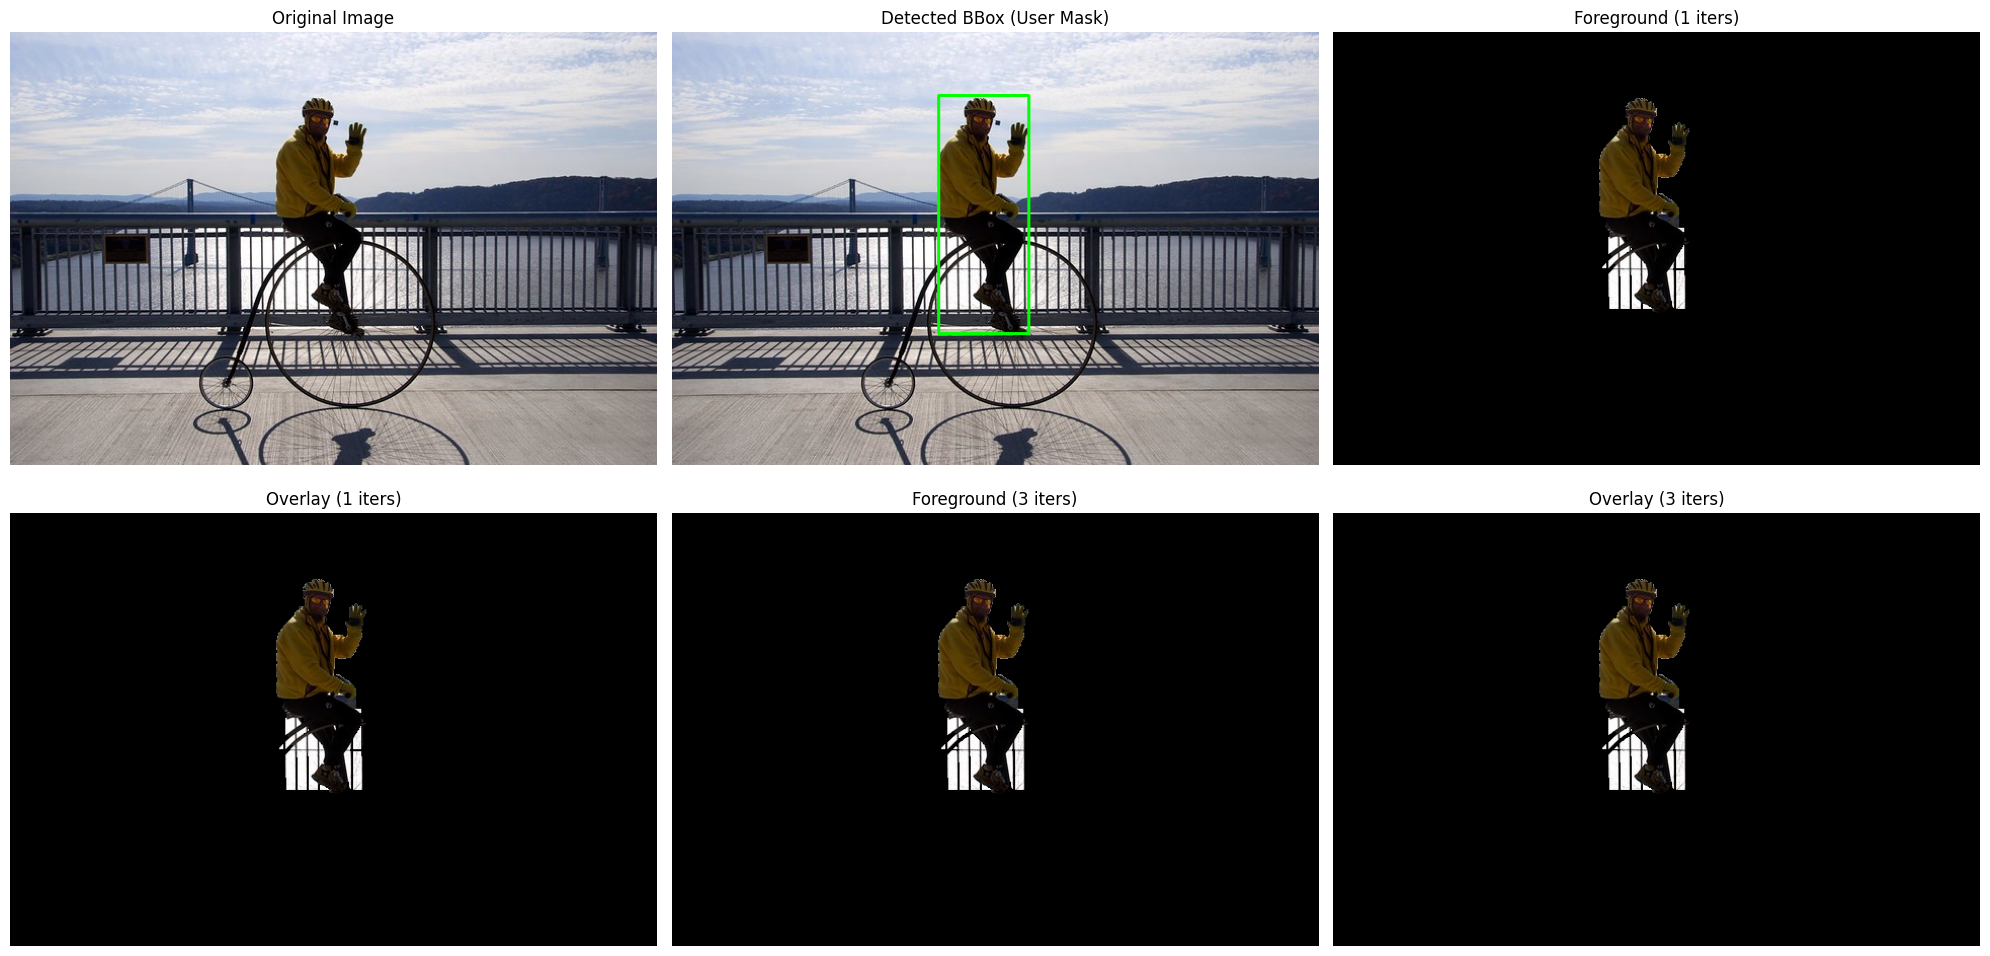


Processing ../assets/asm-2.jpg
Found person with bounding box: (np.int64(190), np.int64(46), np.int64(259), np.int64(205))
Running GrabCut for 1 iteration(s)...
Running GrabCut for 3 iteration(s)...
Running GrabCut for 5 iteration(s)...

Quantitative Differences:
  - 1 iterations: 27265 pixels
  - 3 iterations: 17345 pixels
  - 5 iterations: 17136 pixels

Qualitative Differences:
1 iteration: It gives a rough outline and may miss complex parts.
3 iterations: This is generally a good refinement, captures more detail.
5 iterations: Further refinement, but may start to 'bleed' into the background.


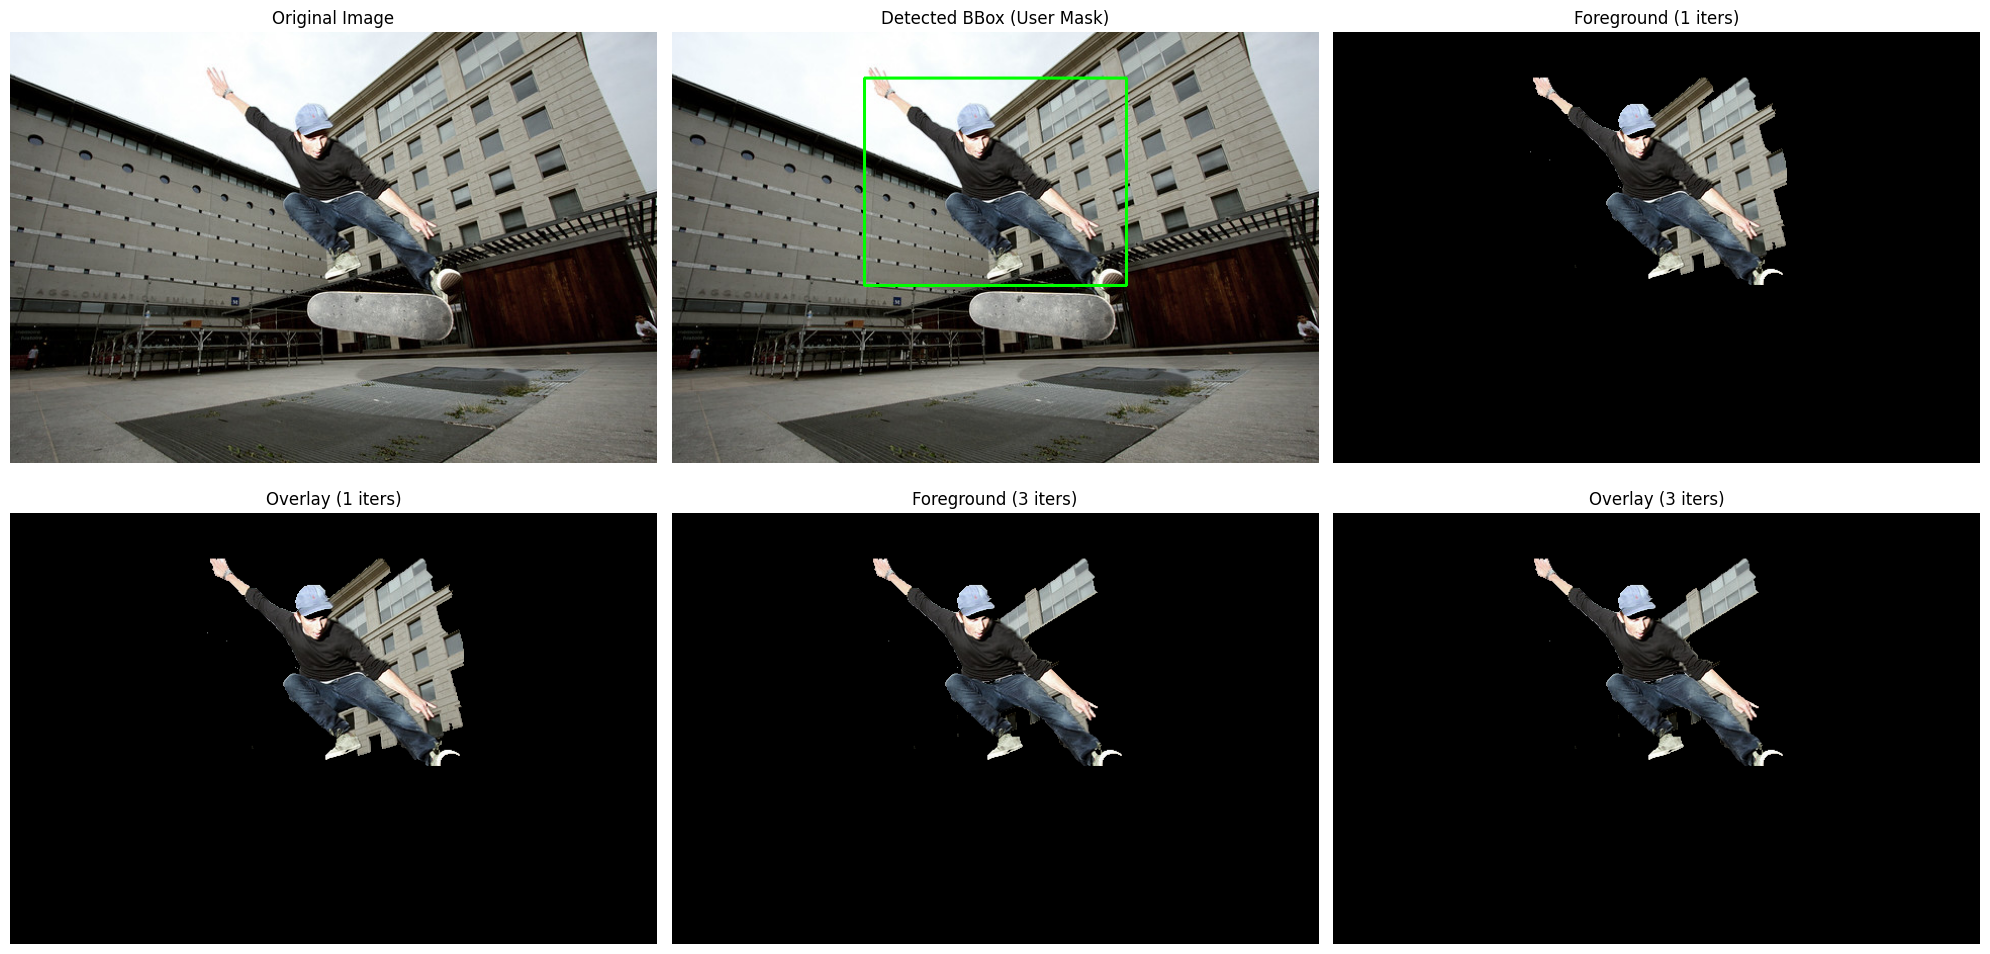

In [10]:
if __name__ == "__main__":
    main()